# Generate Clean Data

`Input:` level 1 raw data (see the `download_data` notebook to get this data)

`Output:` level 2 cleaned and clipped data

This notebook processes the large, raw data files for this project. This mainly means cropping the large images to the target alluvial fan in Eberswalde crater, which requires manipulation of map projections and coordinate reference systems (CRS). We also clean the data by removing NaNs where they appear and replacing them with the median pixel value in the image.

You can skip this notebook and just download the level 2 or level 3 data in the `download_data` notebook if you want. This notebook is here for reproducibility and open-source purposes.

### Import libraries and define some useful helper function

In [67]:
import geopandas as gpd
from shapely.geometry import box
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import richdem as rd
import dask.array as da
from shapely.geometry import Polygon
from pyproj import CRS, Transformer

data_path = '/Users/tthomas/Documents/research/mars-geomorph_ML/TRENT_DEV/' # Where is the level 1 data stored? Change this for your machine
save_path = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data_lvl2_cleaned-clipped/' # Where should the level 2 data be saved? Change this for your machine

In [3]:
def quick_plot(data, title=None):
    # Function that quickly plots and image and value histogram

    # Remove NaN values for the histogram
    data_values = data.values.flatten()
    data_values = data_values[~np.isnan(data_values)]
    data_values = data_values[~np.isinf(data_values)]

    # Create the histogram
    n, bins = np.histogram(data_values, bins=50)

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the histogram
    ax[1].stairs(n, bins)
    ax[1].set_title(f"{title} Histogram")
    ax[1].set_xlabel("Value")
    ax[1].set_ylabel("Frequency")

    # Plot the reprojected DEM image
    data.plot(ax=ax[0])
    ax[0].set_title(title)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [29]:
def reproject_polygon(polygon, source_crs, target_crs):
    # Function to reproject a polygon from one CRS to another

    transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
    reprojected_coords = [transformer.transform(x, y) for x, y in polygon.exterior.coords]
    reprojected_polygon = Polygon(reprojected_coords)
    return reprojected_polygon

In [80]:
def replace_nan_or_inf_with_median(data_array, name):
    """
    Replace NaN or infinite values in the given xarray DataArray with the median value.
    
    Parameters:
    data_array (xarray.DataArray): The input data array.
    name (str): The name of the data array for printing purposes.
    
    Returns:
    xarray.DataArray: The modified data array with NaN or infinite values replaced.
    """
    data_values = data_array.values
    nan_or_inf_mask = np.isnan(data_values) | np.isinf(data_values)

    if np.any(nan_or_inf_mask):
        print(f"NaN or inf values detected in the {name} image")
        median_value = np.nanmedian(data_values)
        data_values[nan_or_inf_mask] = median_value
        data_array.values = data_values

    # Verify the replacement
    print(f"NaN or inf values replaced with median in {name}:",
          np.any(np.isnan(data_array.values)) or np.any(np.isinf(data_array.values)))
    return data_array

## Find Eberswalde fan on Mars using the Morgan et al. 2022 database

Link: https://doi.org/10.1016/j.icarus.2022.115137

Link: https://doi.org/10.1016/j.dib.2022.108494

We use the shapefiles from the Morgan et al. 2022 database for alluvial fans on Mars. This database contains the location of every fan-shaped sedimentary landform on the surface of Mars (n = 1501). The authors mapped fan outlines and associated drainage basins and collected a number of morphologic metrics. The fan-ID of interest in Eberswalde crater is `07-1-15599_1`. 

In [4]:
# Load the shapefiles into a geopandas dataframe
outlinesShapefilePath = data_path + 'data/morganData/Morgan2022_FanDatabase_outlines.shp'
gdf = gpd.read_file(outlinesShapefilePath) # Read the apex shapefile

# Add some additional columns to the dataframe to include: bounding boxes for each fan and the CTX image tile names
lat_bins = ((gdf.loc[:,"apex_lat_N"] - (gdf.loc[:,"apex_lat_N"]%4))).to_numpy(dtype=int)
lon_bins = ((gdf.loc[:,"apex_lon_E"] - (gdf.loc[:,"apex_lon_E"]%4))).to_numpy(dtype=int)
ctx_tile_names = []
ctx_folder_names = []

bounds = gdf["geometry"].bounds
boxes = []
for i in range(len(lat_bins)):
    lat = lat_bins[i]
    lon = lon_bins[i]

    if lat < 10 and lat >= 0:
        lat_str = "0" + str(lat)
    elif lat < 0 and lat > -10:
        lat_str = "-0" + str(abs(lat))
    else:
        lat_str = str(lat)
    
    if lon < 100 and lon >= 10:
        lon_str = "0" + str(lon)
    elif lon < 10 and lon >= 0:
        lon_str = "00" + str(lon)
    elif lon < 0 and lon > -10:
        lon_str = "-00" + str(abs(lon))
    elif lon <= -10 and lon > -100:
        lon_str = "-0" + str(abs(lon))
    else:
        lon_str = str(lon)

    folder_name = "MurrayLab_GlobalCTXMosaic_V01_E" + lon_str + "_N" + lat_str
    ctx_folder_names.append(folder_name)
    
    tile_name = "MurrayLab_CTX_V01_E" + lon_str + "_N" + lat_str + "Mosaic.tif"
    ctx_tile_names.append(tile_name)

    bbox = box(bounds.iloc[i,0],bounds.iloc[i,1],bounds.iloc[i,2],bounds.iloc[i,3])
    boxes.append(bbox)
    
gdf["ctx_tile_names"] = ctx_tile_names
gdf["ctx_folder_names"] = ctx_folder_names
gdf["boxes"] = boxes
gdf["boxes"] = gdf["boxes"].astype('geometry') # this is a critical line and took forever to figure out!

# We already know what tile Eberswalde crater is in, so we can filter the dataframe to only include fans in Eberswalde crater
eb_tile_name = "MurrayLab_GlobalCTXMosaic_V01_E-036_N-24"
gdf_tile = gdf[gdf["ctx_folder_names"] == eb_tile_name]

# Now lets get our fan of interest
fan_id = "07-1-15599_1"
gdf_eb = gdf_tile[gdf_tile["fan_id"] == fan_id]
box_mask = gdf_eb["boxes"]

# Print diagnostics
print("Eberswalde Fan Info")
print(f"CTX Tile Name: {eb_tile_name}")
print(f"Morgan Database Fan ID: {fan_id}")

# Print the coordinates of the bounding box
bbox_coords = box_mask.iloc[0].bounds
print(f"Bounding Box Coordinates:")
print(f"  Min Longitude: {bbox_coords[0]}")
print(f"  Min Latitude: {bbox_coords[1]}")
print(f"  Max Longitude: {bbox_coords[2]}")
print(f"  Max Latitude: {bbox_coords[3]}")

# Print the CRS and map projection information
crs_info = gdf.crs
print("\n Morgan database Coordinate Reference System (CRS) Information:")
print(f"  CRS Name: {crs_info.name}")
print(f"  CRS Type: {'Projected' if crs_info.is_projected else 'Geographic'}")
print(f"  EPSG Code: {crs_info.to_epsg()}")

print("\n More info:")
gdf_eb.head()

Eberswalde Fan Info
CTX Tile Name: MurrayLab_GlobalCTXMosaic_V01_E-036_N-24
Morgan Database Fan ID: 07-1-15599_1
Bounding Box Coordinates:
  Min Longitude: -1999243.3856951222
  Min Latitude: -1421081.492399999
  Max Longitude: -1984003.3551951163
  Max Latitude: -1406716.4085

 Morgan database Coordinate Reference System (CRS) Information:
  CRS Name: SimpleCylindrical_Mars
  CRS Type: Projected
  EPSG Code: None

 More info:


fan_id         fan_type  \
685  07-1-15599_1  Channelized SFD   

                                             reference   CRATER_ID  \
685  Malin and Edgett (2003) (10.1126/science.10905...  07-1-15599   

     apex_lat_N  apex_lon_E  apex_el_km  f_area_km2  bearing f_sl_deg  ...  \
685  -23.818211  -33.727402   -1.311801  116.309364    292.5       NA  ...   

            c_mea_el_m c_med_el_m          c_rel_km conc_src conc conc_R2  \
685  -20.7452092668498          2  1.81380102539062       NA   NA      NA   

                                              geometry  \
685  POLYGON ((-1999181.616 -1411817.227, -1997287....   

                             ctx_tile_names  \
685  MurrayLab_CTX_V01_E-036_N-24Mosaic.tif   

                             ctx_folder_names  \
685  MurrayLab_GlobalCTXMosaic_V01_E-036_N-24   

                                                 boxes  
685  POLYGON ((-1984003.355 -1421081.492, -1984003....  

[1 rows x 26 columns]

## CTX Images

Now let's load in the CTX imagery, locate the Eberswalde fan, and crop the CTX imagery to the bounding box. First, we need to make sure the CRS is the same for the box mask and for the CTX imagery.

In [30]:
ctx_path = data_path + "data/murrayData/MurrayLab_GlobalCTXMosaic_V01_E-036_N-24/MurrayLab_CTX_V01_E-036_N-24_Mosaic.tif"
ctx = rxr.open_rasterio(ctx_path, cache=False, chunks=True)

crs_info = ctx.rio.crs
print("CTX Imagery Coordinate Reference System (CRS) Information:")
print(f"  CRS: {crs_info.to_string()}")
print(f"  CRS Type: {'Projected' if crs_info.is_projected else 'Geographic'}")
print(f"  EPSG Code: {crs_info.to_epsg()}")

CTX Imagery Coordinate Reference System (CRS) Information:
  CRS: PROJCS["Mars_2015_Ocentric_Equirectangular_clon_0",GEOGCS["GCS_Mars_2015_Ocentric",DATUM["Mars (2015)",SPHEROID["Mars_2015",3396190,169.894447223612],AUTHORITY["IAU","49901"]],PRIMEM["Reference Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  CRS Type: Projected
  EPSG Code: None


Now let's clip the image, plot it, and look at the histogram of values.

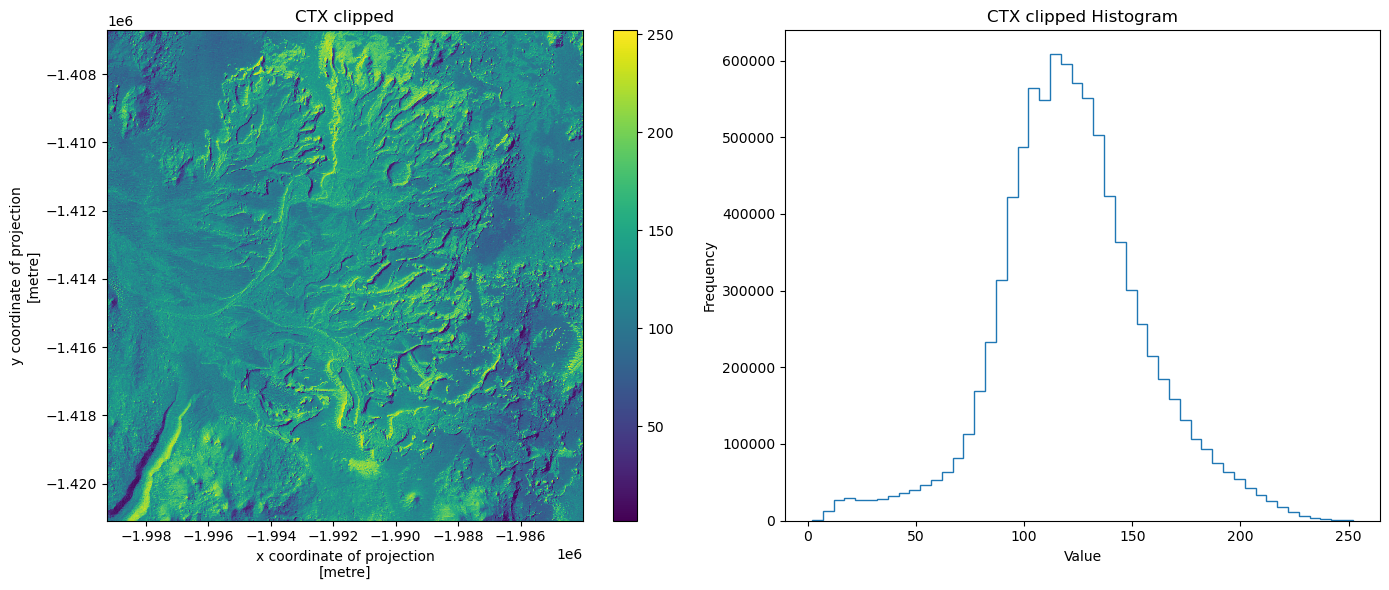

In [31]:
# Reproject the box mask to the same CRS as the CTX imagery, then clip
source_crs = gdf_eb.crs
target_crs = ctx.rio.crs
polygon = gdf_eb["boxes"].iloc[0]
reprojected_polygon = reproject_polygon(polygon, source_crs, target_crs)
ctx_clipped = ctx.rio.clip([reprojected_polygon], target_crs).compute()
quick_plot(ctx_clipped, "CTX IMG clipped")

## CTX DEM

Now lets do the same thing for the CTX-based DEM.

CTX Imagery Coordinate Reference System (CRS) Information:
  CRS: PROJCS["M_S326.38023531065",GEOGCS["GCS_Mars_2000_Sphere",DATUM["<custom>",SPHEROID["<custom>",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",326.38023531065],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  CRS Type: Projected
  EPSG Code: None


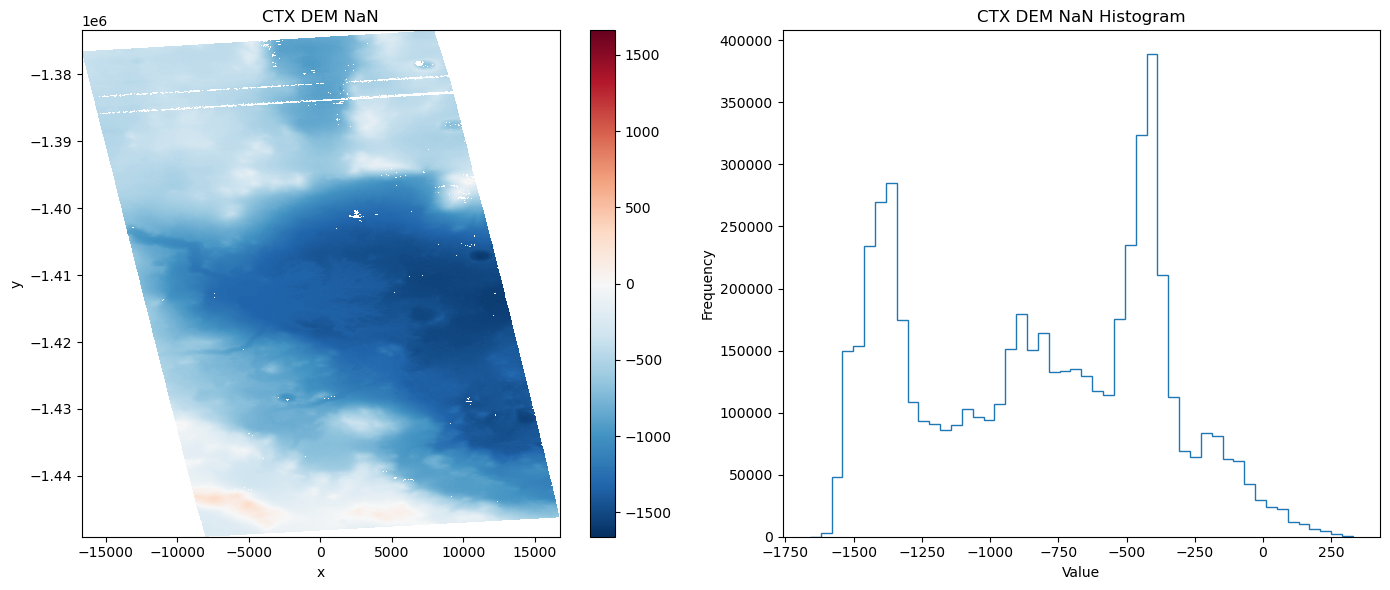

In [59]:
# Read the DEM and projection

ctxDEM_prj_path = data_path + "data/ctxDEMs/P01_001336_1560_P01_001534_1559_tied-DEM.prj"
ctxDEM_path = data_path + "data/ctxDEMs/P01_001336_1560_P01_001534_1559_tied-DEM.tif"
ctxDEM_prj = open(ctxDEM_prj_path).read()
ctxDEM = rxr.open_rasterio(ctxDEM_path,cache=False)
ctxDEM = ctxDEM.rio.set_crs(ctxDEM_prj)

crs_info = ctxDEM.rio.crs
print("CTX Imagery Coordinate Reference System (CRS) Information:")
print(f"  CRS: {crs_info.to_string()}")
print(f"  CRS Type: {'Projected' if crs_info.is_projected else 'Geographic'}")
print(f"  EPSG Code: {crs_info.to_epsg()}")

ctxDEM_nan = ctxDEM.where(ctxDEM >= -30000, np.nan)
ctxDEM_nan = ctxDEM_nan.rio.set_crs(ctxDEM_prj)
quick_plot(ctxDEM_nan,"CTX DEM NaN")

Looks like it needs a reprojection to match the CTX imagery and some additional cleaning. Let's do that now.

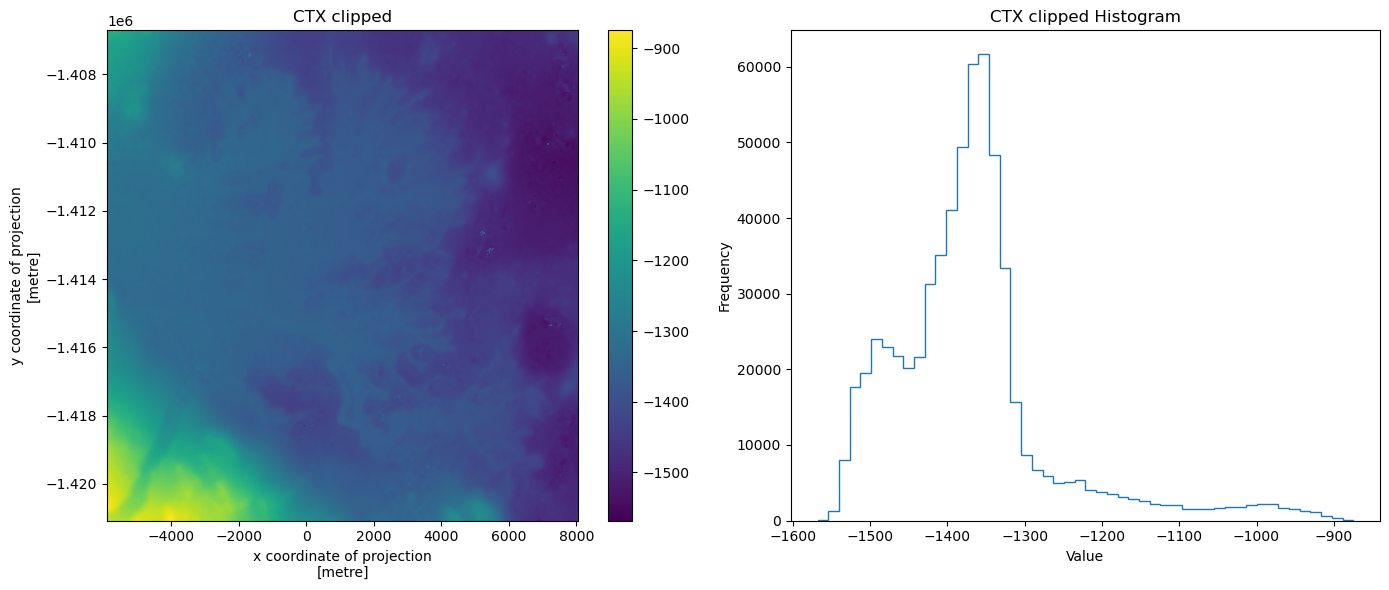

In [62]:
# Reproject the box mask to the same CRS as the CTX DEM, then clip
source_crs = gdf_eb.crs
target_crs = ctxDEM_nan.rio.crs
polygon = gdf_eb["boxes"].iloc[0]
reprojected_polygon = reproject_polygon(polygon, source_crs, target_crs)
ctxDEM_clipped = ctxDEM_nan.rio.clip([reprojected_polygon], target_crs).compute()
ctxDEM_clipped[:,:,:] = np.nan_to_num(ctxDEM_clipped,nan=np.nanmedian(ctxDEM_clipped)) # replace NaNs with median value
quick_plot(ctxDEM_clipped, "CTX DEM clipped")

## CTX Slope

Now we need to calculate a slope map from the DEM.

In [63]:
# Calculate slope using richdem
rd_temp = rd.rdarray(ctxDEM_nan[0, :, :].to_numpy(), no_data=np.nan)
ctxSLOPE_rd = rd.TerrainAttribute(rd_temp, attrib='slope_riserun')
ctxSLOPE = ctxDEM.copy()
ctxSLOPE[:,:,:]= ctxSLOPE_rd
ctxSLOPE = ctxSLOPE.rio.set_crs(ctxDEM_prj)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.104078======================= ] (99% - 0.0s - 1 threads)


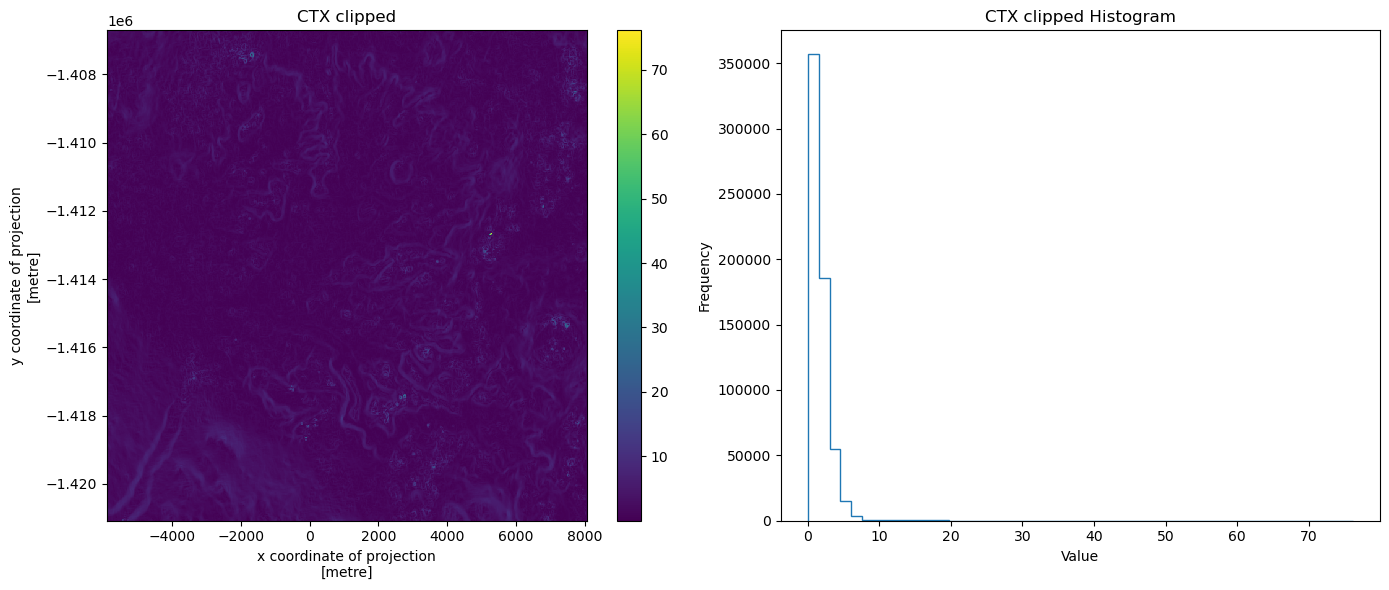

In [64]:
# Reproject the box mask to the same CRS as the CTX DEM, then clip
source_crs = gdf_eb.crs
target_crs = ctxSLOPE.rio.crs
polygon = gdf_eb["boxes"].iloc[0]
reprojected_polygon = reproject_polygon(polygon, source_crs, target_crs)

ctxSLOPE_clipped = ctxSLOPE.rio.clip([reprojected_polygon], target_crs).compute()
ctxSLOPE_clipped[:,:,:] = np.nan_to_num(ctxSLOPE_clipped,nan=np.nanmedian(ctxSLOPE_clipped)) # replace NaNs with median value
quick_plot(ctxSLOPE_clipped, "CTX slope clipped")

### Check for NaN, then save the ctx files

In [79]:
ctx_clipped = replace_nan_or_inf_with_median(ctx_clipped, "CTX clipped")
ctxDEM_clipped = replace_nan_or_inf_with_median(ctxDEM_clipped, "CTX DEM clipped")
ctxSLOPE_clipped = replace_nan_or_inf_with_median(ctxSLOPE_clipped, "CTX SLOPE clipped")

NaN or inf values replaced with median in CTX clipped: False
NaN or inf values replaced with median in CTX DEM clipped: False
NaN or inf values replaced with median in CTX SLOPE clipped: False


In [68]:
ctx_clipped.rio.to_raster(save_path + "ctxIMG_clipped.tif")
ctxDEM_clipped.rio.to_raster(save_path + "ctxDEM_clipped.tif")
ctxSLOPE_clipped.rio.to_raster(save_path + "ctxSLOPE_clipped.tif")

## MOLA/HRSC Blended DEM and SLOPE

Now we process the MOLA/HRSC Blended DEM and SLOPE just like we did above.

CTX Imagery Coordinate Reference System (CRS) Information:
  CRS: PROJCS["Mars_2015_Ocentric_Equirectangular_clon_0",GEOGCS["GCS_Mars_2015_Ocentric",DATUM["Mars (2015)",SPHEROID["Mars_2015",3396190,169.894447223612]],PRIMEM["Reference Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  CRS Type: Projected
  EPSG Code: None


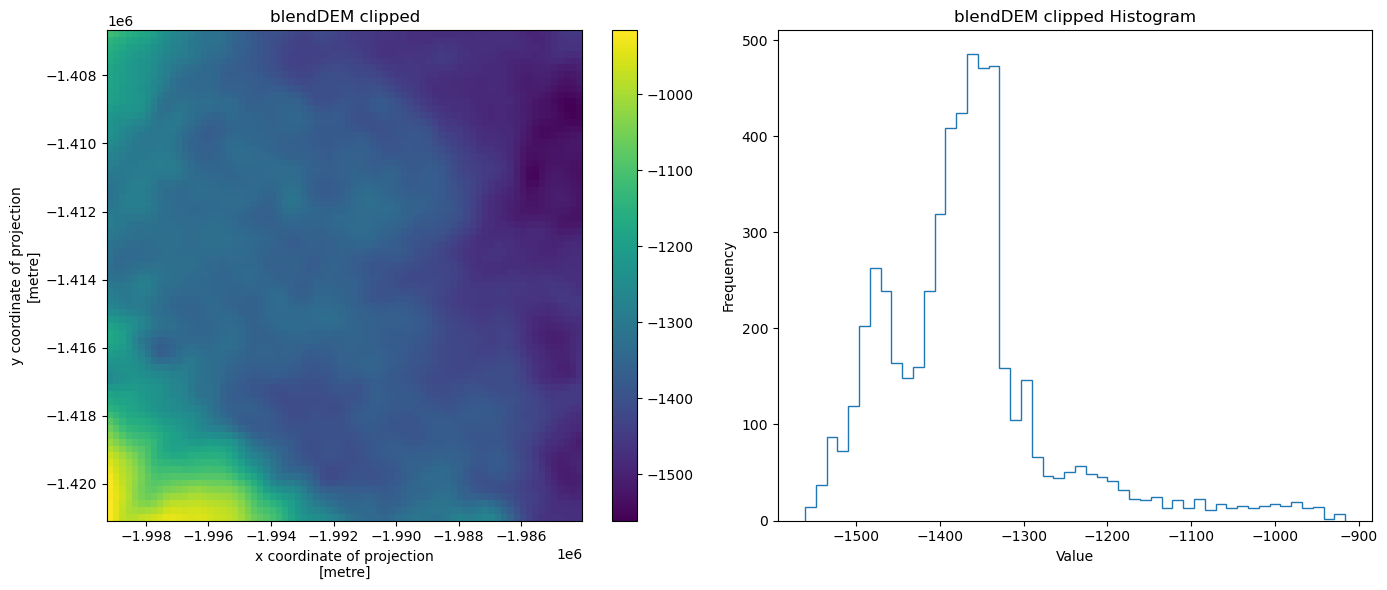

In [69]:
blendDEM_path = data_path + "data/molaHRSCBlendData/Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2_PROJ2CTX.tif"
blendDEM = rxr.open_rasterio(blendDEM_path, cache=False, chunks=True)

crs_info = blendDEM.rio.crs
print("blendDEM Imagery Coordinate Reference System (CRS) Information:")
print(f"  CRS: {crs_info.to_string()}")
print(f"  CRS Type: {'Projected' if crs_info.is_projected else 'Geographic'}")
print(f"  EPSG Code: {crs_info.to_epsg()}")

# Reproject the box mask to the same CRS as the CTX imagery, then clip
source_crs = gdf_eb.crs
target_crs = blendDEM.rio.crs
polygon = gdf_eb["boxes"].iloc[0]
reprojected_polygon = reproject_polygon(polygon, source_crs, target_crs)
blendDEM_clipped = blendDEM.rio.clip([reprojected_polygon], target_crs).compute()
quick_plot(blendDEM_clipped, "blendDEM clipped")

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000949917==================== ] (98% - 0.0s - 1 threads)


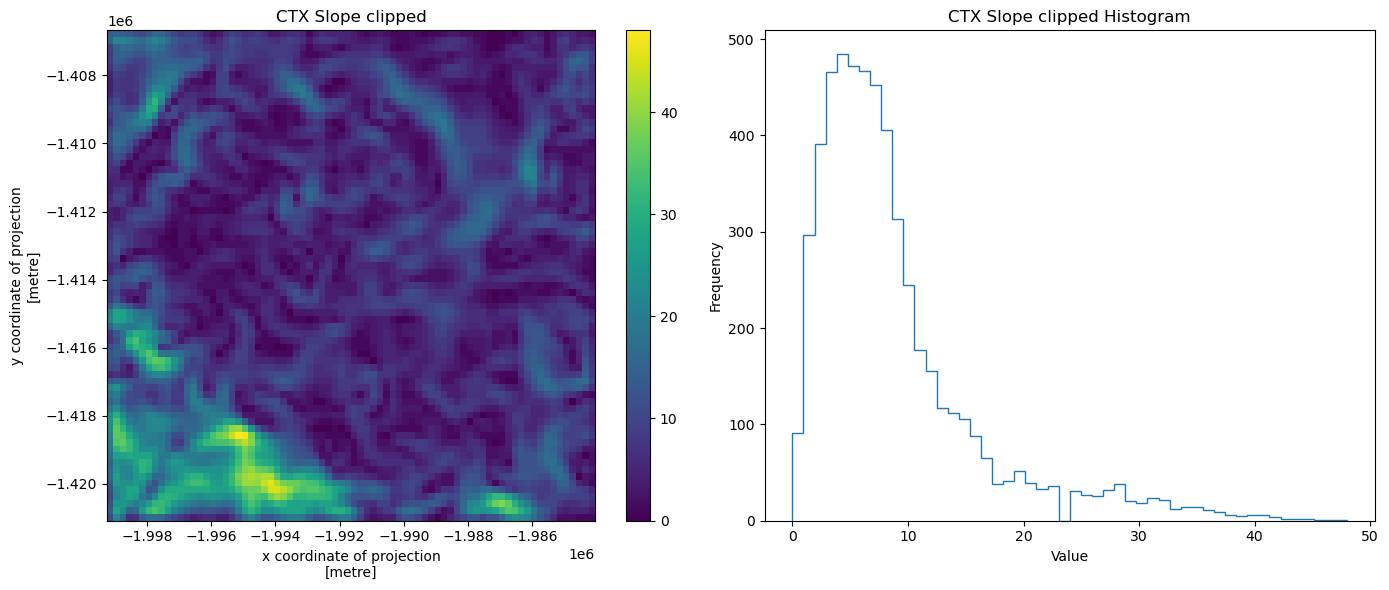

In [70]:
# Calculate slope using richdem
rd_temp = rd.rdarray(blendDEM_clipped[0, :, :].to_numpy(), no_data=np.nan)
blendSLOPE_rd = rd.TerrainAttribute(rd_temp, attrib='slope_riserun')
blendSLOPE_clipped = blendDEM_clipped.copy()
blendSLOPE_clipped[:,:,:]= blendSLOPE_rd

quick_plot(blendSLOPE_clipped,"blendSlope clipped")

### Save the blend files

In [82]:
blendDEM_clipped = replace_nan_or_inf_with_median(blendDEM_clipped, "blendDEM clipped")
blendSLOPE_clipped = replace_nan_or_inf_with_median(blendSLOPE_clipped, "blendSLOPE clipped")

NaN or inf values replaced with median in blendDEM clipped: False
NaN or inf values replaced with median in blendSLOPE clipped: False


In [71]:
blendDEM_clipped.rio.to_raster(save_path + "blendDEM_clipped.tif")
blendSLOPE_clipped.rio.to_raster(save_path + "blendSLOPE_clipped.tif")

## THEMIS dayIR and night IR - PROBLEM WITH THE PROJECTION

CTX Imagery Coordinate Reference System (CRS) Information:
  CRS: PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  CRS Type: Projected
  EPSG Code: None


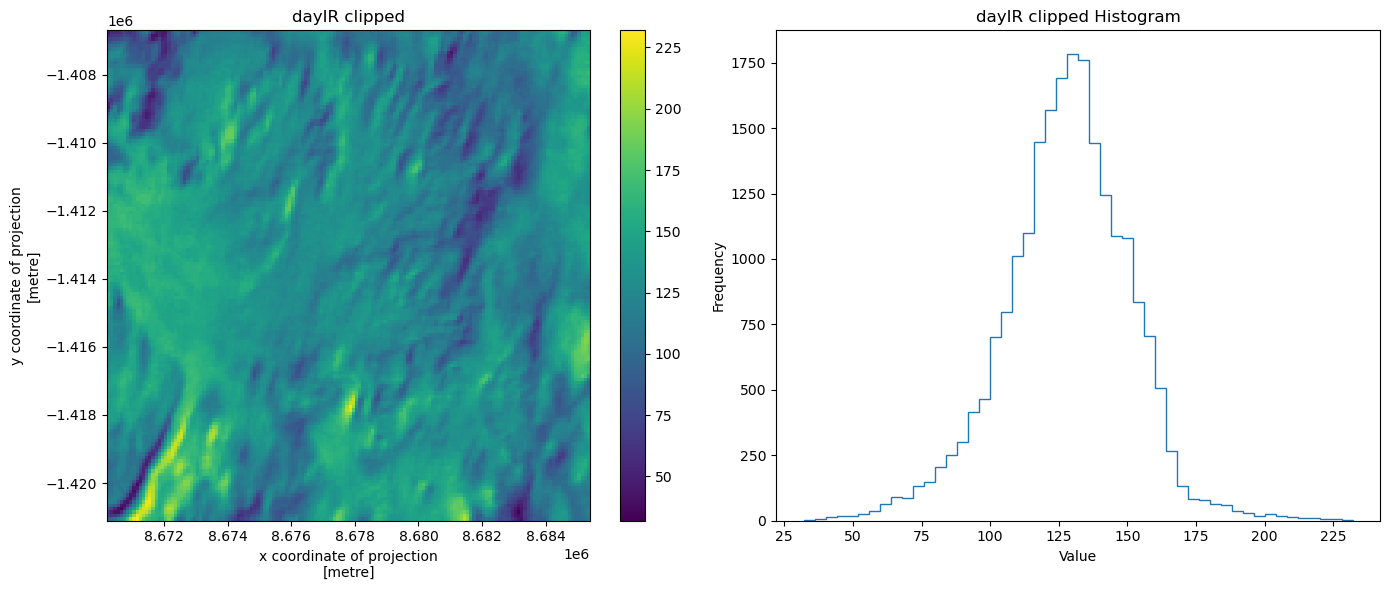

In [72]:
dayIR_path = data_path + "data/themisData/Mars_MO_THEMIS-IR-Day_mosaic_global_100m_v12.tif"
dayIR = rxr.open_rasterio(dayIR_path,chunks=True, cache=False)

crs_info = dayIR.rio.crs
print("CTX Imagery Coordinate Reference System (CRS) Information:")
print(f"  CRS: {crs_info.to_string()}")
print(f"  CRS Type: {'Projected' if crs_info.is_projected else 'Geographic'}")
print(f"  EPSG Code: {crs_info.to_epsg()}")

source_crs = gdf_eb.crs
target_crs = dayIR.rio.crs
polygon = gdf_eb["boxes"].iloc[0]
reprojected_polygon = reproject_polygon(polygon, source_crs, target_crs)
dayIR_clipped = dayIR.rio.clip([reprojected_polygon], target_crs).compute()
quick_plot(dayIR_clipped, "dayIR clipped")

CTX Imagery Coordinate Reference System (CRS) Information:
  CRS: PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  CRS Type: Projected
  EPSG Code: None


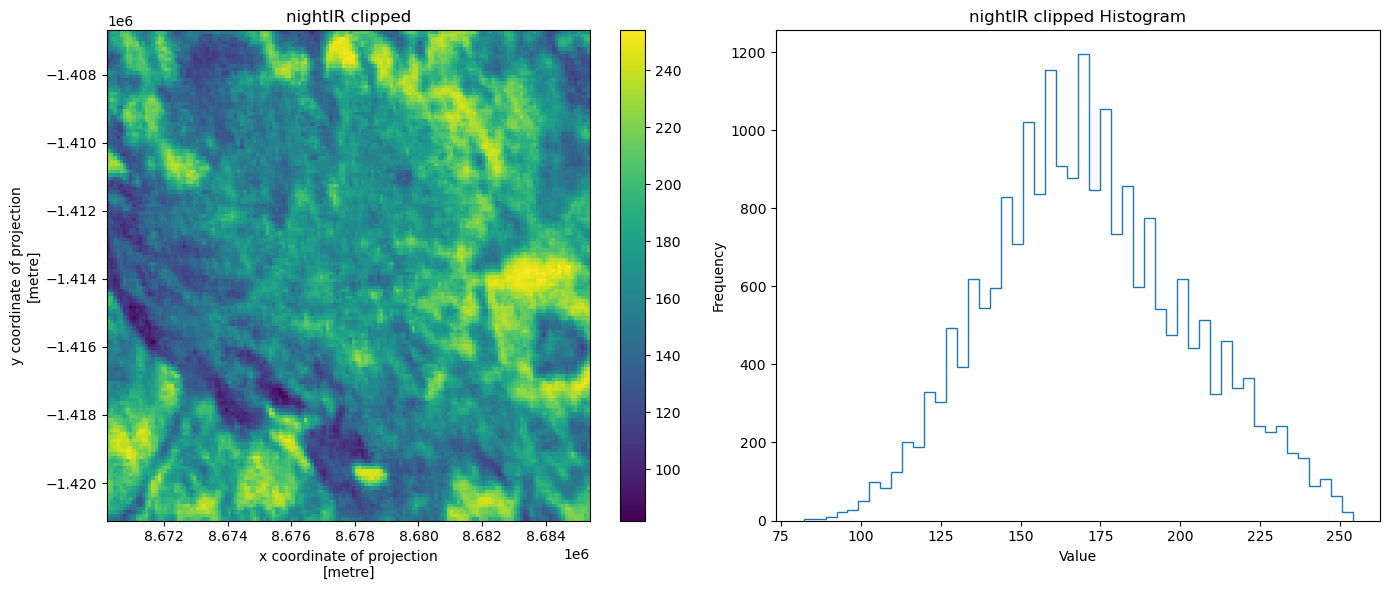

In [74]:
nightIR_path = data_path + "data/themisData/Mars_MO_THEMIS-IR-Night_mosaic_60N60S_100m_v14.tif"
nightIR = rxr.open_rasterio(nightIR_path, chunks=True)

crs_info = nightIR.rio.crs
print("CTX Imagery Coordinate Reference System (CRS) Information:")
print(f"  CRS: {crs_info.to_string()}")
print(f"  CRS Type: {'Projected' if crs_info.is_projected else 'Geographic'}")
print(f"  EPSG Code: {crs_info.to_epsg()}")

source_crs = gdf_eb.crs
target_crs = nightIR.rio.crs
polygon = gdf_eb["boxes"].iloc[0]
reprojected_polygon = reproject_polygon(polygon, source_crs, target_crs)
nightIR_clipped = nightIR.rio.clip([reprojected_polygon], target_crs).compute()
quick_plot(nightIR_clipped, "nightIR clipped")

### Save the THEMIS files

In [81]:
dayIR_clipped = replace_nan_or_inf_with_median(dayIR_clipped, "dayIR clipped")
nightIR_clipped = replace_nan_or_inf_with_median(dayIR_clipped, "nightIR clipped")

NaN or inf values replaced with median in dayIR clipped: False
NaN or inf values replaced with median in nightIR clipped: False


In [75]:
dayIR_clipped.rio.to_raster(save_path + "dayIR_clipped.tif")
nightIR_clipped.rio.to_raster(save_path + "nightIR_clipped.tif")

## HRSC Panchromatic images

In [14]:
hrscND_path = data_path + "data/HRSCvisData/h4310_0000_nd4.tif"
hrscP1_path = data_path + "data/HRSCvisData/h4310_0000_p14.tif"
hrscP2_path = data_path + "data/HRSCvisData/h4310_0000_p24.tif"
hrscS1_path = data_path + "data/HRSCvisData/h4310_0000_s14.tif"
hrscS2_path = data_path + "data/HRSCvisData/h4310_0000_s24.tif"

hrscND = rxr.open_rasterio(hrscND_path,cache=False, chunks=True)
hrscP1 = rxr.open_rasterio(hrscP1_path,cache=False, chunks=True)
hrscP2 = rxr.open_rasterio(hrscP2_path,cache=False, chunks=True)
hrscS1 = rxr.open_rasterio(hrscS1_path,cache=False, chunks=True)
hrscS2 = rxr.open_rasterio(hrscS2_path,cache=False, chunks=True)

# Function to print CRS information
def print_crs_info(raster, name):
    crs_info = raster.rio.crs
    print(f"{name} CRS Information:")
    print(f"  CRS: {crs_info.to_string()}")
    print(f"  CRS Type: {'Projected' if crs_info.is_projected else 'Geographic'}")
    print(f"  EPSG Code: {crs_info.to_epsg()}")
    print()

# Print CRS information for all HRSC images
print_crs_info(hrscND, "HRSC ND")
print_crs_info(hrscP1, "HRSC P1")
print_crs_info(hrscP2, "HRSC P2")
print_crs_info(hrscS1, "HRSC S1")
print_crs_info(hrscS2, "HRSC S2")

HRSC ND CRS Information:
  CRS: PROJCS["SINUSOIDAL MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",326],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  CRS Type: Projected
  EPSG Code: None

HRSC P1 CRS Information:
  CRS: PROJCS["SINUSOIDAL MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",326],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  CRS Type: Projected
  EPSG Code: None

HRSC P2 CRS Information:
  CRS: PROJCS["SINUSOIDAL MARS",GEOGCS["GCS_MARS",DATUM["D_MA

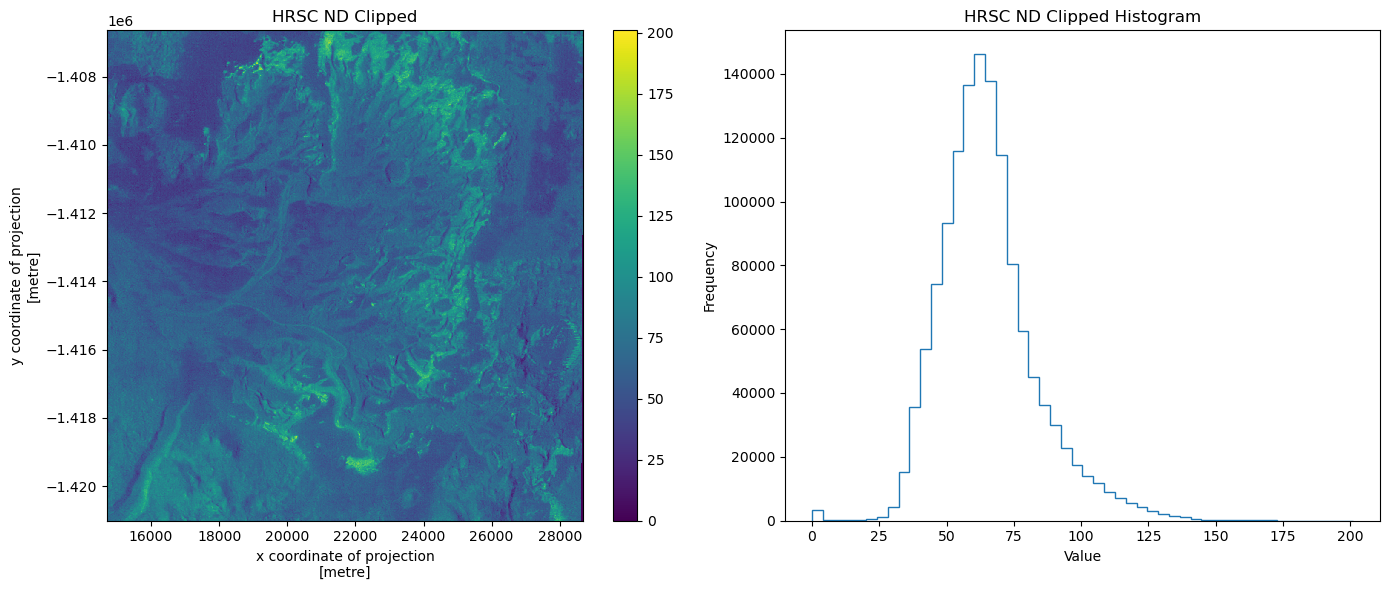

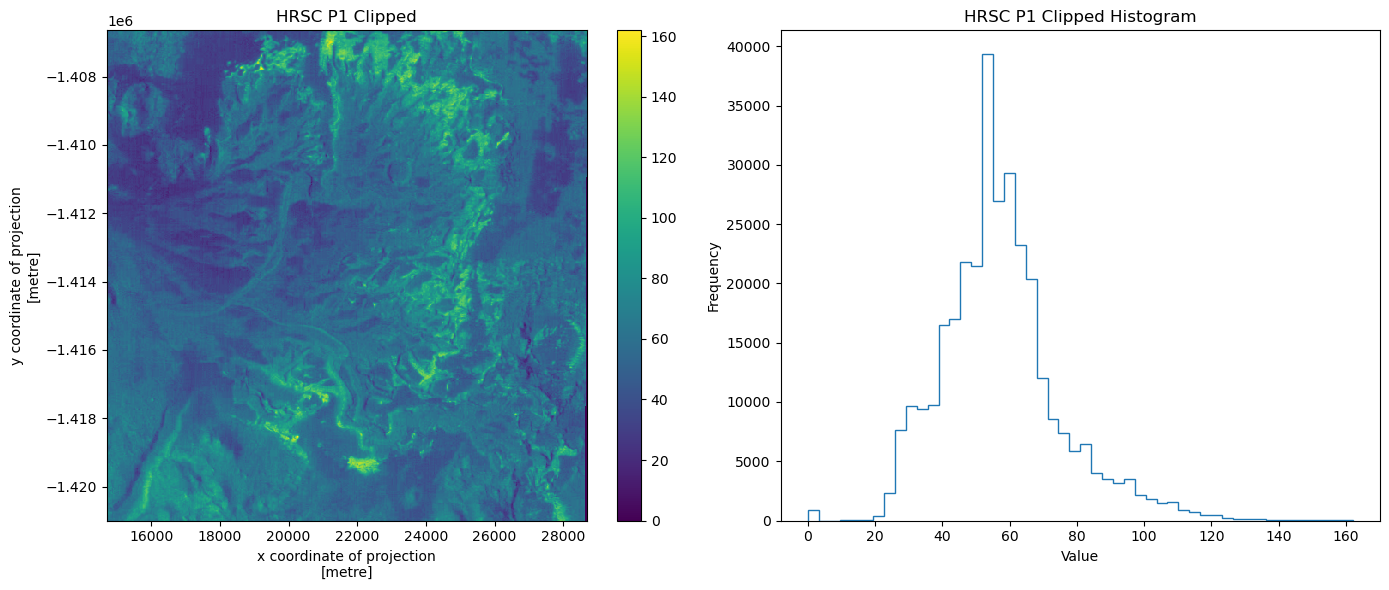

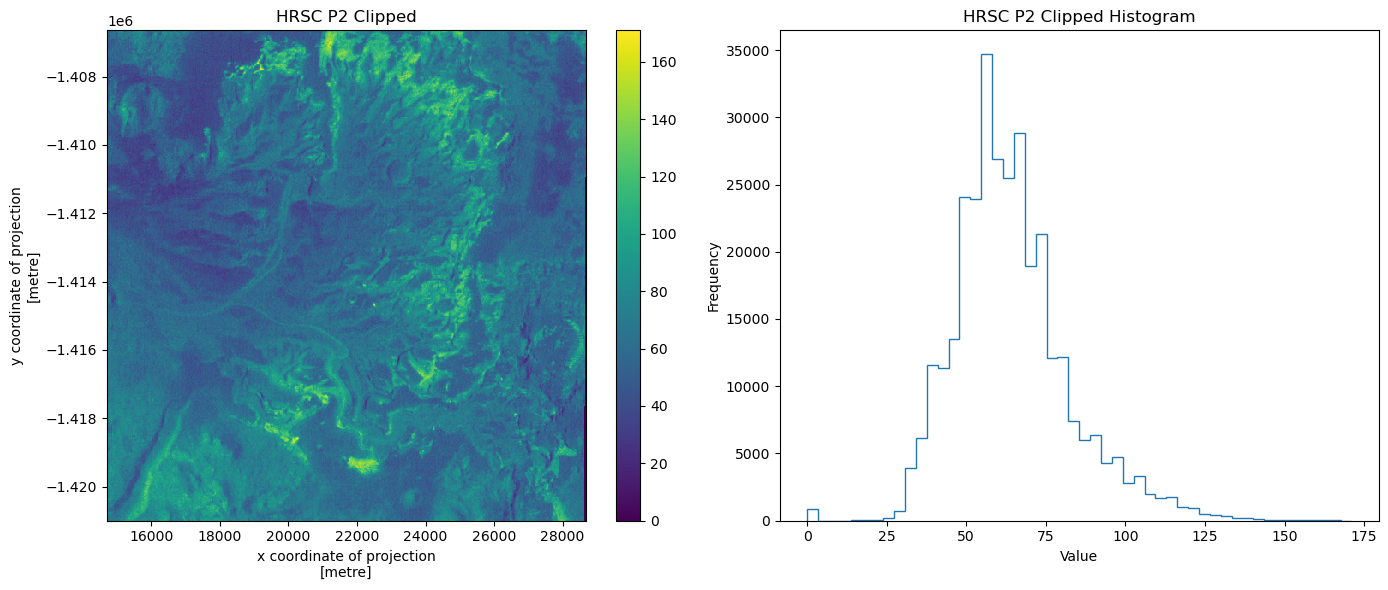

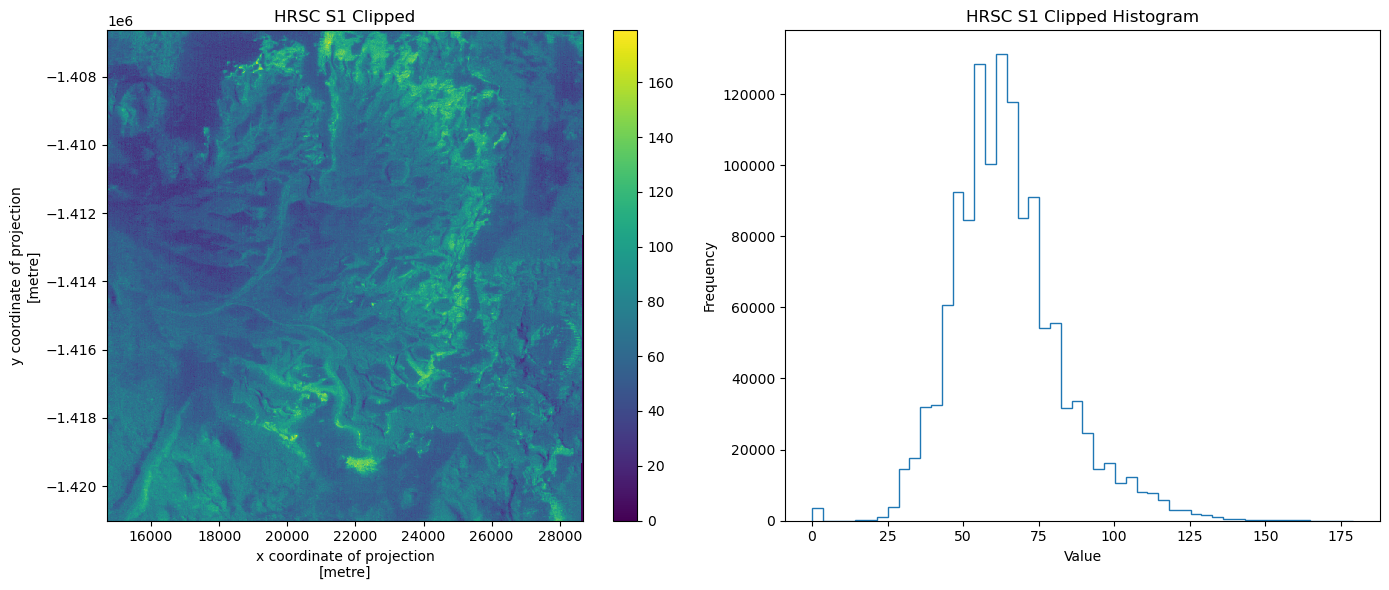

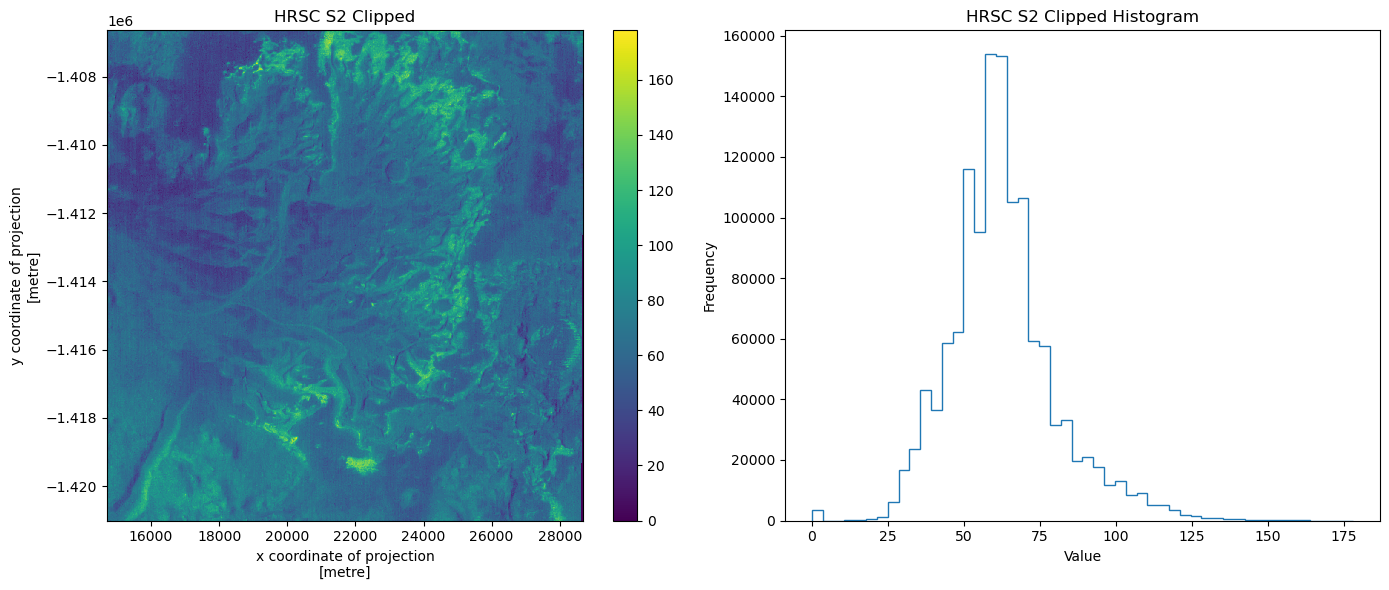

In [76]:
source_crs = gdf_eb.crs
target_crs = hrscND.rio.crs # Use the CRS of the HRSC ND image - all HRSC images have the same CRS
polygon = gdf_eb["boxes"].iloc[0]
reprojected_polygon = reproject_polygon(polygon, source_crs, target_crs)

hrscND_clipped = hrscND.rio.clip([reprojected_polygon], target_crs).compute()
hrscP1_clipped = hrscP1.rio.clip([reprojected_polygon], target_crs).compute()
hrscP2_clipped = hrscP2.rio.clip([reprojected_polygon], target_crs).compute()
hrscS1_clipped = hrscS1.rio.clip([reprojected_polygon], target_crs).compute()
hrscS2_clipped = hrscS2.rio.clip([reprojected_polygon], target_crs).compute()

quick_plot(hrscND_clipped, "HRSC ND Clipped")
quick_plot(hrscP1_clipped, "HRSC P1 Clipped")
quick_plot(hrscP2_clipped, "HRSC P2 Clipped")
quick_plot(hrscS1_clipped, "HRSC S1 Clipped")
quick_plot(hrscS2_clipped, "HRSC S2 Clipped")


In [77]:
hrscND_clipped.rio.to_raster(save_path + "hrscND_clipped.tif")
hrscP1_clipped.rio.to_raster(save_path + "hrscP1_clipped.tif")
hrscP2_clipped.rio.to_raster(save_path + "hrscP2_clipped.tif")
hrscS1_clipped.rio.to_raster(save_path + "hrscS1_clipped.tif")
hrscS2_clipped.rio.to_raster(save_path + "hrscS2_clipped.tif")

# Viola! We now have level 2 cleaned and clipped data for the Eberswalde fan of interest.